# Measured energy and the Compton Data Space

On this tutorial we'll calculate the basic event parameters that will allows us to do spectroscopy and imaging, as will get a peak at how the measured data space looks like.

First, let's imports some libraries and initialize our traditional detector (~COMPTEL) from the previous tutorial:

In [1]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u

det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

Let's run some sims again, but this time let's simulate something closer to a what an astrophysical source looks like. They are so far that the photons come to us as plane waves. Although all photons from a point source that reached the detector have nearly the same direction, they arrive at different positions on the detector.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

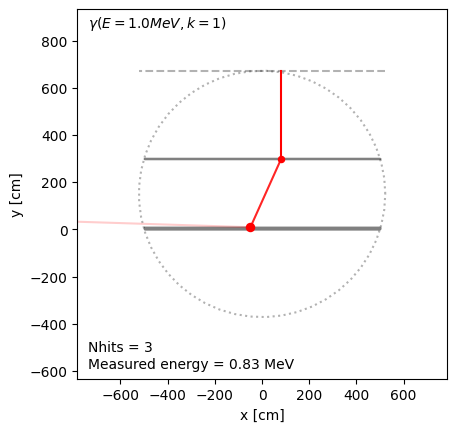

In [2]:
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum

# This is the location of the source in the detector coordinates.
# In COSI we call it "Nu", and since we live in a 3D world, 
# we need two coordinates -> NuLambda
source_offaxis_angle =  0*u.deg

# For simplicity, we'll simulate a mono-energetic source
source_energy = 1*u.MeV

source = PointSource(offaxis_angle = source_offaxis_angle,
                     spectrum = MonoenergeticSpectrum(source_energy))

# All photon from a mono-energetic point source have the 
# same energy and direction, but arrived at different location
# random_photo() get this position at random 
primary = source.random_photon(detector = det)

# See below for a description of the surrounding circle and throwing plane
sim_event = det.simulate_event(primary)
det.plot(event = sim_event,
         draw_surrounding_circle = True)

This time we set `draw_surrounding_circle = True`, which will draw circle that fully encloses the detector --which would be an sphere in our 3D world-- as well as a straight line (the "throwing plane" in 3D) that has the same length as the surrounding circle diameters, and perpendicular to the direction of the photon. 

<div class="alert alert-block alert-info">
<b>Exercise: </b>
Try running the previous cell multiple time to get a feeling for how the simulation work. Also try changing the off_axis angle of the source.
</div>


We use the surrounding sphere to avoid simulating too many photons that have no chance at interacting with the detector, while still keeping the thrown plan area the same for all direction, allowing to correctly normalize the flux. Given the total photon flux of a source and duration of the obaservations, we can compute total number of events from a source in our thrown plane as:

In [3]:
flux = 1/u.cm/u.s # Unit of 1/u.cm/u.s in flatland, 1/u.cm/u.cm/u.s in our world!
duration = 1*u.s
nsim = flux*duration*det.throwing_plane_size

# One extra step to remove the units
# nsim is already unitless, we just need this due to how astropy 
# tracks the units. See for yourself:
# print(f"Before extra step: {nsim}")
nsim = nsim.to_value(u.dimensionless_unscaled)

print(f"We need to throw ~{nsim:.1f} events "
      f"at our surrounding sphere of size {det.throwing_plane_size:.2f} "
      f"in order to simulate a source with flux={flux} "
      f"over an observation duration of {duration}")

We need to throw ~1044.0 events at our surrounding sphere of size 10.44 m in order to simulate a source with flux=1.0 1 / (cm s) over an observation duration of 1.0 s


## Measured energy

Now, let's see how many of these actually trigger out detector. From the discussion in the last tutorial, a resonable simple event trigger conditions are:
- At least one hit in the top layer (the 0-th layer)
- At least one hit in the bottom layer (which is really group of thin layers)
- The first hit occured on the top layer

Let's simulate a bunch of events, aplying our trigger condition, and attempting to estimate the energy of the primary by summing up the all the hit energies. We'll keep track of them in a histogram.

(0.1, 2)

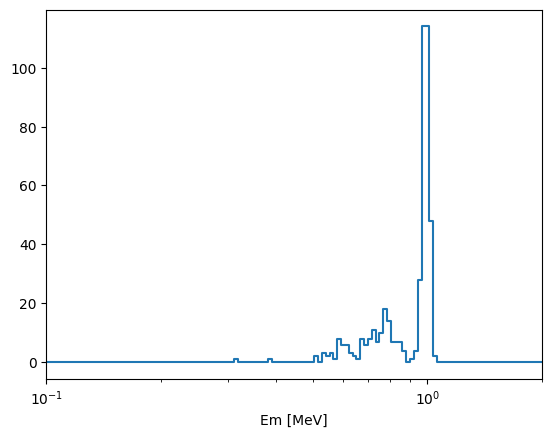

In [4]:
from histpy import Histogram

h_Em = Histogram(np.geomspace(.1,10,200)*u.MeV,
                 labels = "Em",
                 axis_scale = 'log')

for i in range(int(np.round(nsim))):

    primary = source.random_photon(det)
    
    sim_event = det.simulate_event(primary)

    hits = sim_event.hits

    triggered = hits.nhits >= 2 and hits.layer[0] == 0
    
    if not triggered:
        # Didn't meet our trigger condition
        continue

    measured_energy = np.sum(hits.energy)

    h_Em.fill(measured_energy)

ax,_ = h_Em.plot()

ax.set_xlim(.1,2)

We can see two main features
1. The large peak centered at the thrown energy (1MeV in our case). This is called the photopeak. The events within this peak where, the most part, fully absorbed the within the detector. The non-zero width is caused by the finite energy resolution. In addition, if you look closely, you'll see that photopeak is not assymetric, due to some event for which a little bit of their energy scaped or had hits below the detectable energy threshold.
2. The much broader feature on at lower energies, usually called the Compton continuum or should, and the right side called the Compton edge. This is caused by events that largely escaped the detector. The location of the Comton edge is approximately the maximum energy that a photon can transmit to an electron on a single interaction. Based on the Compton kinematic equation this happens for a backscattered event, and the transfered energy is:

$$E_{edge} = E \left(1 - \frac{1}{1+\frac{2E}{m_e c^2}}\right)$$ 

For $E = 1 MeV$, $E_{edge} = 0.796 MeV$

Now, let's see how many events we detected:

In [5]:
ntrig = np.sum(h_Em)
print(ntrig)

457.0


Our efficiency is:

In [6]:
eff = ntrig/nsim

print(f"Efficiency = {eff:.2f}")

Efficiency = 0.44


We can use it to estimate the effective "area" of our detector --or rather, effective "length" in flatland, I guess, but bare with me. That is:

In [7]:
Aeff = det.throwing_plane_size * eff

print(f"Effective \"area\" = {Aeff:.2f}")

Effective "area" = 4.57 m


Alternatively, we can estimate the effective area based on the simulated flux and duration:

In [8]:
ntrig / flux / duration 

<Quantity 457. cm>

Note that the effective area depends on particular direction, energy and trigger condition. Make sure to get all this information to correctly interpret the effective area.

The width of the photopeak is typically quoted as the energy resolution. You can measure it by e.g. fitting it to a Gaussian, but for now, by eye, it's about 50 keV. Sometimes we're interted of knowing the effective area given only the event for which we precisely measured the energy, that is, the "photopeak effective area". For those, we only select those events within the photopeak:

In [9]:
photopeak_width = 50*u.keV # Approximate 1 sigma, by eye
ntrig_photo = np.sum(h_Em.contents[(h_Em.axis.centers < source_energy + 3*photopeak_width) &
                      (source_energy - 3*photopeak_width < h_Em.axis.centers)])

Aeff_photo = ntrig_photo / flux / duration 

print(f"Photopeak effective area = {Aeff_photo:.2f}")

Photopeak effective area = 322.00 cm


exce: sett energy resolution and thhreshold to 0. What improve? Do all in photopeak?
excersize: get the energy range, off-axis dependennce

## The Compton Data Space (CDS)

Don't point back at sources

In [10]:
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum

source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = MonoenergeticSpectrum(1*u.MeV))

h_data = Histogram([np.linspace(0,2,200)*u.MeV,
                    np.linspace(0,180, 180)*u.deg,
                    np.linspace(-180,180, 360)*u.deg],
                    labels = ["Em", "Phi", "Psi"])

for i in range(int(np.round(nsim))):

    primary = source.random_photon(detector = det)
    
    sim_event = det.simulate_event(primary, doppler_broadening = False)

    # det.plot(event = sim_event,
    #           draw_surrounding_circle = True)
    
    hits = sim_event.hits

    triggered = hits.nhits >= 2 and hits.layer[0] == 0
    
    if not triggered:
        # Didn't meet our trigger condition
        continue

    measured_energy = np.sum(hits.energy)

    # Energy and position
    energy_top = hits.energy[0]
    position_top = hits.position[0]
    position_bottom = np.mean(hits.position[hits.layer > 0])

    energy_out = measured_energy - energy_top
    
    #CDS
    cos_phi = 1 + 510.99*u.keV*(1/measured_energy - 1/energy_out)
    if cos_phi < -1:
        # Unphysicl, likely due to a measurement error. Filter out
        continue
    
    phi = np.arccos(cos_phi)
        
    psi = -np.arctan2(position_bottom.x - position_top.x,
                      position_top.y - position_bottom.y)
    
    h_data.fill(measured_energy, phi, psi)

(<Axes: xlabel='Psi [deg]', ylabel='Phi [deg]'>,
 <matplotlib.collections.QuadMesh at 0x1333bd950>)

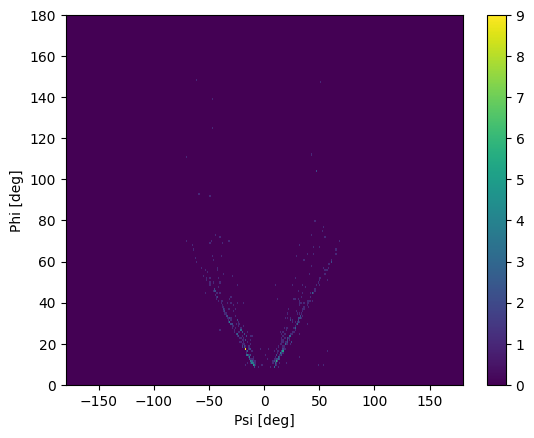

In [11]:
h_cds = h_data.project('Psi','Phi')

h_cds.plot()

exec: play time!
exec: try different energies. Why is the vertex missing?
exce: sett energy resolution and thhreshold to 0. What improve?  Why don't you have high phi event?
exce: Vary the source direction (offaxis axis angle in flatland) and see how that affects the Compton cone. If you look only at the data, can you tell where the source is by eye? Can you see why it is critical to determine the phi from kinematics alone? Why is the cone assymetric, even though we have the same number of left and right chiralities? (in 3D, for polarization, this is instrumental-induced "unpolarized modulation pattern". Trye hitting it from below the horizontal.
excrs: try differres chiralities, with 100 polarization degree. Why it was important to collect high scattering angles.  h_data.slice[:,40:,:].project('Psi').rebin(5).plot()

ARM energ resolution. A few degrees. Tails and non-symetric. No doppler browdening effect, only missed energy.

(<Axes: xlabel='ARM [deg]'>, <ErrorbarContainer object of 3 artists>)

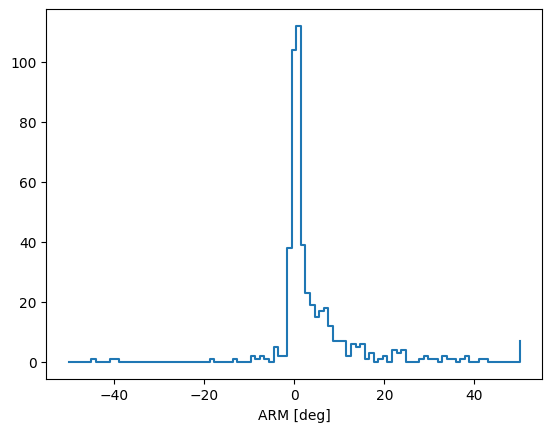

In [12]:
h_arm = Histogram(np.linspace(-50,50,100)*u.deg, labels = 'ARM')

phi_centroids = h_cds.axes['Phi'].centers
psi_centroids = h_cds.axes['Psi'].centers

for nphi,phi in enumerate(phi_centroids):
    for npsi,psi in enumerate(psi_centroids):
        arm = phi - np.abs(psi - source.offaxis_angle) 
        
        h_arm.fill(arm, weight = h_cds[{'Phi':nphi, 'Psi':npsi}])

h_arm.plot()

## Putting it all together

cosima, geo and source file

We simulated 1.0 s (3151) and detected 1000


(<Axes: xlabel='Em [MeV]'>, <ErrorbarContainer object of 3 artists>)

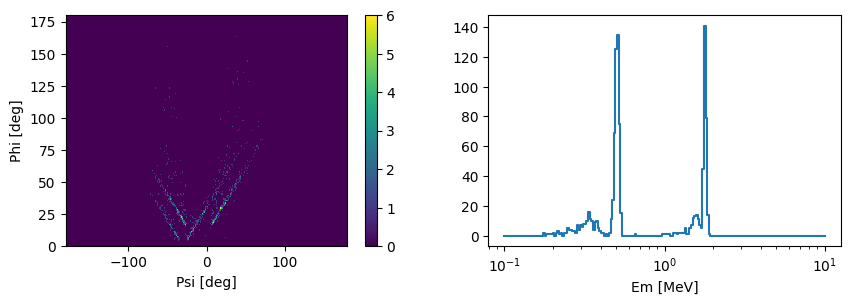

In [20]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, MonoenergeticSpectrum
import matplotlib.pyplot as plt

# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

# Sources
source_1 = PointSource(offaxis_angle = -10*u.deg,
                       spectrum = MonoenergeticSpectrum(511*u.keV),
                       flux = 2/u.cm/u.s)

source_2 = PointSource(offaxis_angle = -30*u.deg,
                       spectrum = MonoenergeticSpectrum(1.8*u.MeV),
                       flux = 1/u.cm/u.s)

# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()

# Sims
sims = Simulator(detector = det, 
                 sources = [source_1, source_2], 
                 reconstructor = reco,
                 ntrig = 1000)

h_data = sims.run_binned()

# Summary and plot
print(f"We simulated {sims.duration:.2} ({sims.nsim}) and detected {sims.ntrig}")
fig,ax = plt.subplots(figsize = [10,3], ncols = 2)
h_data.project('Psi','Phi').plot(ax[0])
h_data.project('Em').plot(ax[1])

Exec: cut in EM and plot on psichi